# This is the work notebook of the final project.
# The aim of this project is to create a route planner service for pedestrians with disabilities or difficulties with walking. 
# The inspiration for this work came from the motivational quiet path route service we were shown on one class and from a collegue who is working with accessibility topics.
# I received some spatial accessibility data from the city of Helsinki via a collegue. The city officials hoped some sort of tool to see 
# which routes where accessible to which usergroups. I didn't have time to fully take in count the different user groups.

In [93]:

import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import requests
import geojson
import matplotlib
%matplotlib inline
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import shapely.speedups
import folium
import contextily as ctx
from pyproj import CRS
import osmnx as ox
import networkx as nx

import mplleaflet

In [94]:
# This data consists of Special accessibility level areas such as squares or pedestrian streets.
etasonAlueet = gpd.read_file("Lahtotiedot/Erikoistason_alueet_shp-export/HKRPTY_esteettomyys_erikois_alue_areas.shp")

In [95]:
# Let's see what kind of data it is.
print("Aineistossa on ", len(etasonAlueet), " riviä")
print(etasonAlueet.iloc[0:1]['geometry'])

Aineistossa on  72  riviä
0    POLYGON ((25506632.826 6677060.280, 25506711.7...
Name: geometry, dtype: geometry


In [96]:
# This is the special accessibility level pedestrian and wheelchair routes.
etasonReitit = gpd.read_file("Lahtotiedot/Erikoistason_reitti_toteutunut/HKRPTY_esteettomyys_TOT_erikois_reitti_lines.shp")

In [97]:
print("Aineistossa on ", len(etasonReitit), " riviä")
etasonReitit.head()
etasonReitit.crs

Aineistossa on  868  riviä


{'proj': 'tmerc',
 'lat_0': 0,
 'lon_0': 25,
 'k': 1,
 'x_0': 25500000,
 'y_0': 0,
 'ellps': 'GRS80',
 'units': 'm',
 'no_defs': True}

In [98]:
# This data consists of the voice signageg traffic lights for blind people.
aaniopasteet = gpd.read_file("Lahtotiedot/HELSINKI1_OjalaKi_20191219_160434 (1)/HKRPTY_esteettomyys_TOT_aaniopas_suojat.tab")

In [99]:
print("Aineistossa on ", len(aaniopasteet), " riviä")
aaniopasteet.head()

Aineistossa on  351  riviä


gml_id  tunniste   luokka1  \
0  HKRPTY_esteettomyys_TOT_aaniopas_suojat.1329         0  Suojatie   
1  HKRPTY_esteettomyys_TOT_aaniopas_suojat.1595         0  Suojatie   
2  HKRPTY_esteettomyys_TOT_aaniopas_suojat.1496         0  Suojatie   
3  HKRPTY_esteettomyys_TOT_aaniopas_suojat.1636         0  Suojatie   
4  HKRPTY_esteettomyys_TOT_aaniopas_suojat.4485         0  Suojatie   

     luokka2 lisatieto1  lisatieto2 toteutunut_esteettomyys  \
0  Perustaso    Saareke  Ääniohjaus                           
1  Perustaso             Ääniohjaus                           
2  Perustaso    Saareke  Ääniohjaus                           
3  Perustaso    Saareke  Ääniohjaus                           
4  Perustaso             Ääniohjaus                           

                                            geometry  
0  LINESTRING (25493826.180 6680518.470, 25493798...  
1  LINESTRING (25495099.200 6675162.230, 25495114...  
2  LINESTRING (25493562.120 6677184.470, 25493548...  
3  LINESTRING (25491658.650 6679548.940, 25491644...  
4  LINESTRING (25496965.080 6677438.790, 25496960...

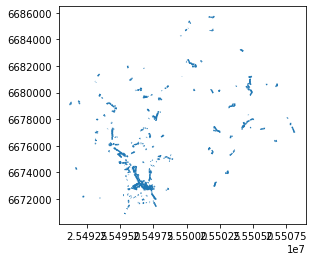

In [100]:
# Let's see where the special level routes are.
etasonReitit.plot()

In [101]:
# For folium package we need to change the crs into WGS84
print(etasonReitit.crs)
etasonReititWGS84 = etasonReitit.to_crs(epsg=4326)
aaniopasteetWGS84 = aaniopasteet.to_crs(epsg=4326)
etasonAlueetWGS84 = etasonAlueet.to_crs(epsg=4326)

etasonReititWGS84.tail()

{'proj': 'tmerc', 'lat_0': 0, 'lon_0': 25, 'k': 1, 'x_0': 25500000, 'y_0': 0, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}


gml_id tunniste   luokka1  \
863  HKRPTY_esteettomyys_TOT_erikois_reitti.16820     None  Suojatie   
864  HKRPTY_esteettomyys_TOT_erikois_reitti.16828     None    Reitti   
865  HKRPTY_esteettomyys_TOT_erikois_reitti.15858     None    Reitti   
866  HKRPTY_esteettomyys_TOT_erikois_reitti.15862     None    Reitti   
867  HKRPTY_esteettomyys_TOT_erikois_reitti.16195     None    Reitti   

         luokka2 lisatieto1  lisatieto2 toteutunut  \
863  Erikoistaso    Saareke  Ääniohjaus      Kyllä   
864  Erikoistaso       None        None      Kyllä   
865  Erikoistaso       None        None      Kyllä   
866  Erikoistaso       None        None      Kyllä   
867  Erikoistaso       None        None      Kyllä   

                                              geometry  
863  LINESTRING (25.07630 60.20932, 25.07634 60.20920)  
864  LINESTRING (25.05878 60.19061, 25.05942 60.190...  
865  LINESTRING (24.95509 60.16783, 24.95571 60.167...  
866  LINESTRING (24.95592 60.16921, 24.95668 60.169...  
867  LINESTRING (24.96672 60.20276, 24.96660 60.202...

In [102]:
# There are some columns that mean the same thing but are written in a different way in different datasets. 
# Let's unify them, so we can unite the data later on.
etasonAlueetWGS84 = etasonAlueetWGS84.rename(
    columns={'TUNNISTE' : 'tunniste', 'LUOKKA1' : 'luokka1',
            'LUOKKA2' : 'luokka2', 'LISATIETO1' : 'lisatieto1',
            'LISATIETO2' : 'lisatieto2'})

In [103]:
etasonAlueetWGS84.head()

gml_id  tunniste luokka1      luokka2        lisatieto1  \
0   None      38.0   Asema  Erikoistaso        Metroasema   
1   None      54.0   Asema  Erikoistaso        Metroasema   
2   None      51.0  Keskus  Erikoistaso  Vuosaaren keskus   
3   None      53.0   Asema  Erikoistaso        Metroasema   
4   None      39.0    None  Erikoistaso              None   

             lisatieto2                 AIKA   TEKIJA  \
0   Rastilan metroasema  2016-10-05T14:35:44  AHellén   
1  Siilitien metroasema  2016-10-05T14:35:44  AHellén   
2                  None  2016-10-05T14:35:44  AHellén   
3  Vuosaaren metroasema  2016-10-05T14:35:44  AHellén   
4                  None  2016-10-05T14:35:44  AHellén   

                                            geometry  
0  POLYGON ((25.11961 60.20627, 25.12104 60.20603...  
1  POLYGON ((25.04348 60.20503, 25.04454 60.20587...  
2  POLYGON ((25.14372 60.20811, 25.14446 60.20827...  
3  POLYGON ((25.14054 60.20736, 25.14398 60.20760...  
4  POLYGON ((25.07641 60.20848, 25.07641 60.20848...

In [104]:
# Next we fetch a Graph from Open Street Map so we can make shortest path analysis.
# I checked some boundaries for the graph from Open Street Map webmap and set them as a bounding box for the graph.

polyBorder = Polygon([(24.850000, 60.200000), (24.990000, 60.200000),
                     (24.990000, 60.150000), (24.850000, 60.150000)])
graph = ox.graph_from_bbox(north=60.183715, south=60.160687, east=24.965640, 
                           west=24.917896, network_type='walk')

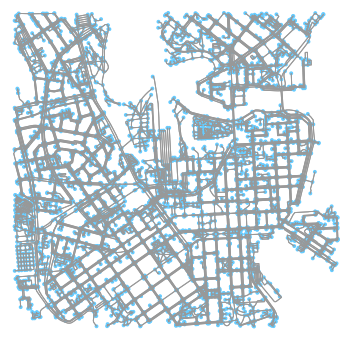

In [105]:
# Let's see what it looks like.
fig, ax = ox.plot_graph(graph)

In [106]:
#graphP = ox.project_graph(graph)
aaniopasteetWGS84.tail()

gml_id  tunniste   luokka1  \
346  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16190         0  Suojatie   
347  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16191         0  Suojatie   
348  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16192         0  Suojatie   
349  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16193         0  Suojatie   
350  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16194         0  Suojatie   

       luokka2 lisatieto1  lisatieto2 toteutunut_esteettomyys  \
346  Perustaso             Ääniohjaus                           
347  Perustaso             Ääniohjaus                           
348  Perustaso             Ääniohjaus                           
349  Perustaso             Ääniohjaus                           
350  Perustaso    Saareke  Ääniohjaus                           

                                              geometry  
346  LINESTRING (24.96487 60.21506, 24.96496 60.21498)  
347  LINESTRING (24.96475 60.21516, 24.96465 60.21524)  
348  LINESTRING (24.97006 60.21269, 24.97030 60.21262)  
349  LINESTRING (24.97042 60.21260, 24.97058 60.21256)  
350  LINESTRING (24.96844 60.21076, 24.96897 60.21062)

In [107]:
# Then I continued unifying the data.
aaniopasteetWGS84 = aaniopasteetWGS84.rename(columns=({'toteutunut_esteettomyys' : 'toteutunut'}))
aaniopasteetWGS84.tail()

gml_id  tunniste   luokka1  \
346  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16190         0  Suojatie   
347  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16191         0  Suojatie   
348  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16192         0  Suojatie   
349  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16193         0  Suojatie   
350  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16194         0  Suojatie   

       luokka2 lisatieto1  lisatieto2 toteutunut  \
346  Perustaso             Ääniohjaus              
347  Perustaso             Ääniohjaus              
348  Perustaso             Ääniohjaus              
349  Perustaso             Ääniohjaus              
350  Perustaso    Saareke  Ääniohjaus              

                                              geometry  
346  LINESTRING (24.96487 60.21506, 24.96496 60.21498)  
347  LINESTRING (24.96475 60.21516, 24.96465 60.21524)  
348  LINESTRING (24.97006 60.21269, 24.97030 60.21262)  
349  LINESTRING (24.97042 60.21260, 24.97058 60.21256)  
350  LINESTRING (24.96844 60.21076, 24.96897 60.21062)

In [108]:
# Next I extracted the nodes and edges as geo dataframes.
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

In [109]:
edges.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

In [110]:
print(len(edges))
edges.head()

23190


u           v  key                   osmid  highway  oneway  \
0  3196174340   913578188    0                 8035247  footway   False   
1  3196174340   308783762    0                28788947  footway   False   
2  3196174340   296556313    0                28788947  footway   False   
3  3196174341  3196174350    0  [313613081, 313613084]  service   False   
4   296043616   295064653    0               317591141  footway   False   

   length                                           geometry  \
0   6.557  LINESTRING (24.92952 60.17323, 24.92941 60.17321)   
1   2.043  LINESTRING (24.92952 60.17323, 24.92951 60.17325)   
2  99.141  LINESTRING (24.92952 60.17323, 24.93032 60.172...   
3  16.615  LINESTRING (24.92993 60.17325, 24.92975 60.173...   
4  63.276  LINESTRING (24.93189 60.17067, 24.93254 60.17021)   

             tunnel name service lanes maxspeed bridge access width  ref  \
0               NaN  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   
1               NaN  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   
2               NaN  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   
3  building_passage  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   
4               NaN  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   

  est_width junction  
0       NaN      NaN  
1       NaN      NaN  
2       NaN      NaN  
3       NaN      NaN  
4       NaN      NaN

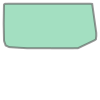

In [111]:
convexHull = edges.unary_union.convex_hull
convexHull

In [112]:
from folium.features import FeatureGroup, GeoJson, TopoJson, Marker

nodesGeoJson = GeoJson(nodes, name="places")
etasonReititGeoJson = GeoJson(etasonReititWGS84, name="etasonReitit")
etasonAlueetGeoJson = GeoJson(etasonAlueetWGS84, name="etasonAlueet")
aaniopasteetGeoJson = GeoJson(aaniopasteetWGS84, name="aaniopasteet")


In [113]:
etasonReititWGS84.to_file("Lahtotiedot/etasonreititkartalle.geojson", driver='GeoJSON')

In [114]:
etasonAlueetWGS84.to_file("Lahtotiedot/etasonalueetkartalle.geojson", driver='GeoJSON')

aaniopasteetWGS84.to_file("Lahtotiedot/aaniopasteetkartalle.geojson", driver='GeoJSON')


In [115]:
edgesGeoJson = GeoJson(edges, name="edges")

In [116]:
etasonReititWGS84 = etasonReititWGS84.loc[(etasonReititWGS84['geometry'].within(convexHull))]
etasonAlueetWGS84 = etasonAlueetWGS84.loc[(etasonAlueetWGS84['geometry'].within(convexHull))]
aaniopasteetWGS84 = aaniopasteetWGS84.loc[(aaniopasteetWGS84['geometry'].within(convexHull))]

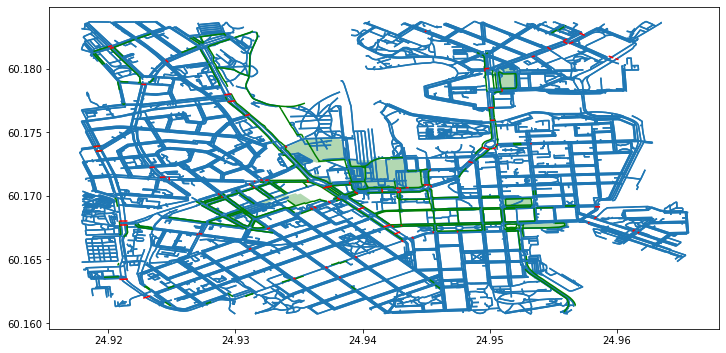

In [117]:
fig, ax = plt.subplots(figsize=(12,12))
edges.plot(ax=ax)
etasonReititWGS84.plot(ax=ax, color='green')
etasonAlueetWGS84.plot(ax=ax, color='green', alpha = 0.3)
aaniopasteetWGS84.plot(ax=ax, color='red')

In [28]:
esteettomyysMap = "Helsingin_keskustan_estettömyys.png"
fig.savefig(esteettomyysMap, dpi=300)

In [118]:
center = convexHull.centroid
center.x


24.941086259162248

In [119]:
from shapely.geometry import mapping
from folium.plugins import MarkerCluster, Search, PolyLineTextPath
from folium.utilities import parse_options
from folium import plugins
import cgi
from osgeo import gdal
# Now we can start visualizing


In [120]:
# I wanted to make buffer areas for the special level routes and voice sinage so that I can use them for the route analysis.
# So I changed the crs to ETRS TM-35 so I can use metres as buffer length.
etasonReititWGS84 = etasonReititWGS84.to_crs(epsg=3879)
aaniopasteetWGS84 = aaniopasteetWGS84.to_crs(epsg=3879)
etasonAlueetWGS84 = etasonAlueetWGS84.to_crs(epsg=3879)
etasonReititWGS84.head()

gml_id tunniste luokka1  \
1    HKRPTY_esteettomyys_TOT_erikois_reitti.2558     None  Reitti   
39  HKRPTY_esteettomyys_TOT_erikois_reitti.10078     None  Reitti   
40  HKRPTY_esteettomyys_TOT_erikois_reitti.10081     None  Reitti   
41  HKRPTY_esteettomyys_TOT_erikois_reitti.10082     None  Reitti   
42  HKRPTY_esteettomyys_TOT_erikois_reitti.10091     None  Reitti   

        luokka2             lisatieto1 lisatieto2 toteutunut  \
1   Erikoistaso  Ei talvikunnossapitoa       None      Kyllä   
39  Erikoistaso                   None       None      Kyllä   
40  Erikoistaso                   None       None      Kyllä   
41  Erikoistaso                   None       None      Kyllä   
42  Erikoistaso                   None       None      Kyllä   

                                             geometry  
1   LINESTRING (25496827.491 6672981.527, 25496957...  
39  LINESTRING (25495585.415 6674315.651, 25495622...  
40  LINESTRING (25496131.809 6673039.414, 25496140...  
41  LINESTRING (25496145.085 6673047.634, 25496145...  
42  LINESTRING (25496839.152 6672748.389, 25496804...

In [121]:
etasonReititWGS84.crs


{'init': 'epsg:3879', 'no_defs': True}

In [122]:
# Then I buffered the routes with 10 metre buffer in case the OSM routes are offset from the data from city of Helsinki. 
# I figured that 10 metres should be enough because it is not that far to walk even for people with dissabilities and sometimes 
# OSM seems locate the "walk"-graph on drive ways which can be quite far from the side walk.
etasonReititWGS84['bufferareas'] = etasonReititWGS84.geometry.buffer(10)

In [123]:
etasonReititWGS84.head()

gml_id tunniste luokka1  \
1    HKRPTY_esteettomyys_TOT_erikois_reitti.2558     None  Reitti   
39  HKRPTY_esteettomyys_TOT_erikois_reitti.10078     None  Reitti   
40  HKRPTY_esteettomyys_TOT_erikois_reitti.10081     None  Reitti   
41  HKRPTY_esteettomyys_TOT_erikois_reitti.10082     None  Reitti   
42  HKRPTY_esteettomyys_TOT_erikois_reitti.10091     None  Reitti   

        luokka2             lisatieto1 lisatieto2 toteutunut  \
1   Erikoistaso  Ei talvikunnossapitoa       None      Kyllä   
39  Erikoistaso                   None       None      Kyllä   
40  Erikoistaso                   None       None      Kyllä   
41  Erikoistaso                   None       None      Kyllä   
42  Erikoistaso                   None       None      Kyllä   

                                             geometry  \
1   LINESTRING (25496827.491 6672981.527, 25496957...   
39  LINESTRING (25495585.415 6674315.651, 25495622...   
40  LINESTRING (25496131.809 6673039.414, 25496140...   
41  LINESTRING (25496145.085 6673047.634, 25496145...   
42  LINESTRING (25496839.152 6672748.389, 25496804...   

                                          bufferareas  
1   POLYGON ((25496957.193 6672995.204, 25496958.1...  
39  POLYGON ((25495631.255 6674247.866, 25495634.1...  
40  POLYGON ((25496149.128 6673028.314, 25496171.7...  
41  POLYGON ((25496135.729 6673052.399, 25496135.9...  
42  POLYGON ((25496811.708 6672732.439, 25496811.6...

In [124]:
# Now let's change the buffer column as the 'geometry' and rename it.

etasonReititWGS84 = etasonReititWGS84.rename(columns={'geometry' : 'linestring', 'bufferareas' : 'geometry'})



In [125]:
etasonReititWGS84 = etasonReititWGS84.set_geometry('geometry')

In [126]:
etasonReititWGS84.head()

gml_id tunniste luokka1  \
1    HKRPTY_esteettomyys_TOT_erikois_reitti.2558     None  Reitti   
39  HKRPTY_esteettomyys_TOT_erikois_reitti.10078     None  Reitti   
40  HKRPTY_esteettomyys_TOT_erikois_reitti.10081     None  Reitti   
41  HKRPTY_esteettomyys_TOT_erikois_reitti.10082     None  Reitti   
42  HKRPTY_esteettomyys_TOT_erikois_reitti.10091     None  Reitti   

        luokka2             lisatieto1 lisatieto2 toteutunut  \
1   Erikoistaso  Ei talvikunnossapitoa       None      Kyllä   
39  Erikoistaso                   None       None      Kyllä   
40  Erikoistaso                   None       None      Kyllä   
41  Erikoistaso                   None       None      Kyllä   
42  Erikoistaso                   None       None      Kyllä   

                                           linestring  \
1   LINESTRING (25496827.491 6672981.527, 25496957...   
39  LINESTRING (25495585.415 6674315.651, 25495622...   
40  LINESTRING (25496131.809 6673039.414, 25496140...   
41  LINESTRING (25496145.085 6673047.634, 25496145...   
42  LINESTRING (25496839.152 6672748.389, 25496804...   

                                             geometry  
1   POLYGON ((25496957.193 6672995.204, 25496958.1...  
39  POLYGON ((25495631.255 6674247.866, 25495634.1...  
40  POLYGON ((25496149.128 6673028.314, 25496171.7...  
41  POLYGON ((25496135.729 6673052.399, 25496135.9...  
42  POLYGON ((25496811.708 6672732.439, 25496811.6...

In [127]:
# The I joined the buffers as one multipolygon. That enables to make fast and easy analysis on whether a line string is 
# on an special accessible route.
reittiyhdiste = etasonReititWGS84.unary_union

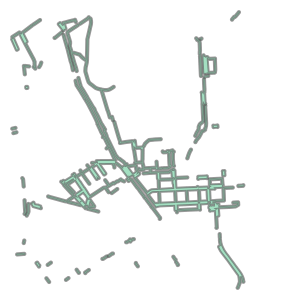

In [128]:
reittiyhdiste

In [129]:
# Then let's do the same with the voice signage.
aaniopasteetWGS84['bufferareas'] = aaniopasteetWGS84['geometry'].buffer(10)
aaniopasteetWGS84 = aaniopasteetWGS84.rename(columns={'geometry' : 'linestring', 'bufferareas' : 'geometry'})



In [130]:
aaniopasteetWGS84 = aaniopasteetWGS84.set_geometry('geometry')

In [131]:
aaniopasteetyhdiste = aaniopasteetWGS84.unary_union



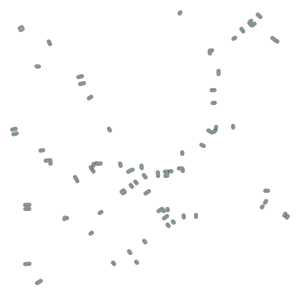

In [132]:
aaniopasteetyhdiste

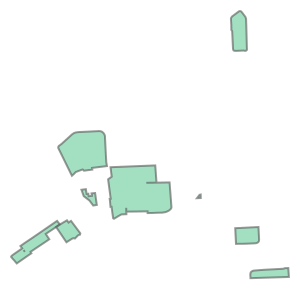

In [133]:
# ... And join the special accessible squares as well.
alueyhdiste = etasonAlueetWGS84.unary_union
alueyhdiste

In [134]:
aaniopasteetWGS84.tail()

gml_id  tunniste   luokka1  \
308  HKRPTY_esteettomyys_TOT_aaniopas_suojat.16469         0  Suojatie   
328  HKRPTY_esteettomyys_TOT_aaniopas_suojat.15835         0  Suojatie   
329  HKRPTY_esteettomyys_TOT_aaniopas_suojat.15836         0  Suojatie   
332  HKRPTY_esteettomyys_TOT_aaniopas_suojat.15847         0  Suojatie   
333  HKRPTY_esteettomyys_TOT_aaniopas_suojat.15848         0  Suojatie   

         luokka2 lisatieto1  lisatieto2 toteutunut  \
308  Erikoistaso             Ääniohjaus              
328    Perustaso             Ääniohjaus              
329    Perustaso             Ääniohjaus              
332    Perustaso             Ääniohjaus              
333    Perustaso             Ääniohjaus              

                                            linestring  \
308  LINESTRING (25497150.360 6673303.990, 25497130...   
328  LINESTRING (25497876.180 6672696.900, 25497868...   
329  LINESTRING (25497658.470 6672781.830, 25497652...   
332  LINESTRING (25497689.400 6672827.970, 25497680...   
333  LINESTRING (25497855.960 6672718.690, 25497847...   

                                              geometry  
308  POLYGON ((25497125.721 6673305.490, 25497124.8...  
328  POLYGON ((25497877.281 6672680.077, 25497876.7...  
329  POLYGON ((25497660.820 6672767.630, 25497660.2...  
332  POLYGON ((25497688.501 6672808.804, 25497687.9...  
333  POLYGON ((25497856.241 6672697.908, 25497855.7...

In [135]:
# I wanted to know more about what kind of data some of the columns had on the OSM edges, but I didn't fully understand what they were. 
# Propably they aren't that important.
edges.loc[edges['access'].notnull()]

u           v  key                             osmid  \
366    3452027200   150501018    0                          26134554   
367    3452027200  3452026292    0                          26134554   
412    5964136804    25473362    0  [631582724, 631582725, 45602486]   
820    3673096875   297282292    0              [29004976, 59148119]   
821    3673096875   733251942    0              [29004976, 59148125]   
...           ...         ...  ...                               ...   
22731   311049857  1005473403    0                         618189328   
22732   311049857  6497762618    0             [692229770, 54819039]   
22733   311049857   299979865    0                         618189328   
22830  1371750101   295055252    0                           8061216   
22833  1371750101   295056712    0                          51707748   

                  highway  oneway   length  \
366               service   False   34.510   
367               service   False   25.290   
412    [footway, service]   False  451.304   
820               footway   False   53.085   
821               footway   False   51.549   
...                   ...     ...      ...   
22731             footway   False    2.470   
22732             footway   False   90.223   
22733             footway   False    7.721   
22830             service   False    9.394   
22833             service   False    9.088   

                                                geometry tunnel name  \
366    LINESTRING (24.91883 60.16931, 24.91830 60.16947)    NaN  NaN   
367    LINESTRING (24.91883 60.16931, 24.91923 60.16919)    NaN  NaN   
412    LINESTRING (24.93828 60.17904, 24.93835 60.179...    NaN  NaN   
820    LINESTRING (24.93792 60.17245, 24.93730 60.172...    yes  NaN   
821    LINESTRING (24.93792 60.17245, 24.93846 60.172...    yes  NaN   
...                                                  ...    ...  ...   
22731  LINESTRING (24.94803 60.16282, 24.94803 60.16279)    NaN  NaN   
22732  LINESTRING (24.94803 60.16282, 24.94772 60.162...    NaN  NaN   
22733  LINESTRING (24.94803 60.16282, 24.94802 60.162...    NaN  NaN   
22830  LINESTRING (24.93613 60.16901, 24.93626 60.16906)    NaN  NaN   
22833  LINESTRING (24.93613 60.16901, 24.93600 60.16896)    NaN  NaN   

        service lanes maxspeed bridge       access width  ref est_width  \
366         NaN   NaN      NaN    NaN  destination   NaN  NaN       NaN   
367         NaN   NaN      NaN    NaN  destination   NaN  NaN       NaN   
412    driveway   NaN      NaN    NaN           no   NaN  NaN       NaN   
820         NaN   NaN      NaN    NaN   permissive   NaN  NaN       NaN   
821         NaN   NaN      NaN    NaN   permissive   NaN  NaN       NaN   
...         ...   ...      ...    ...          ...   ...  ...       ...   
22731       NaN   NaN      NaN    NaN           no   NaN  NaN       NaN   
22732       NaN   NaN      NaN    NaN           no   NaN  NaN       NaN   
22733       NaN   NaN      NaN    NaN           no   NaN  NaN       NaN   
22830       NaN     2      NaN    NaN           no   NaN  NaN       NaN   
22833       NaN   NaN      NaN    NaN           no   NaN  NaN       NaN   

      junction  
366        NaN  
367        NaN  
412        NaN  
820        NaN  
821        NaN  
...        ...  
22731      NaN  
22732      NaN  
22733      NaN  
22830      NaN  
22833      NaN  

[806 rows x 19 columns]

In [136]:
#etasonReititWGS84 = etasonReititWGS84.drop(['linestring'], axis=1)

In [137]:
# Then I changed the dataframes back to WGS84.
etasonReititWGS84 = etasonReitit.to_crs(epsg=4326)
aaniopasteetWGS84 = aaniopasteet.to_crs(epsg=4326)
etasonAlueetWGS84 = etasonAlueet.to_crs(epsg=4326)

etasonReititWGS84.tail()


gml_id tunniste   luokka1  \
863  HKRPTY_esteettomyys_TOT_erikois_reitti.16820     None  Suojatie   
864  HKRPTY_esteettomyys_TOT_erikois_reitti.16828     None    Reitti   
865  HKRPTY_esteettomyys_TOT_erikois_reitti.15858     None    Reitti   
866  HKRPTY_esteettomyys_TOT_erikois_reitti.15862     None    Reitti   
867  HKRPTY_esteettomyys_TOT_erikois_reitti.16195     None    Reitti   

         luokka2 lisatieto1  lisatieto2 toteutunut  \
863  Erikoistaso    Saareke  Ääniohjaus      Kyllä   
864  Erikoistaso       None        None      Kyllä   
865  Erikoistaso       None        None      Kyllä   
866  Erikoistaso       None        None      Kyllä   
867  Erikoistaso       None        None      Kyllä   

                                              geometry  
863  LINESTRING (25.07630 60.20932, 25.07634 60.20920)  
864  LINESTRING (25.05878 60.19061, 25.05942 60.190...  
865  LINESTRING (24.95509 60.16783, 24.95571 60.167...  
866  LINESTRING (24.95592 60.16921, 24.95668 60.169...  
867  LINESTRING (24.96672 60.20276, 24.96660 60.202...

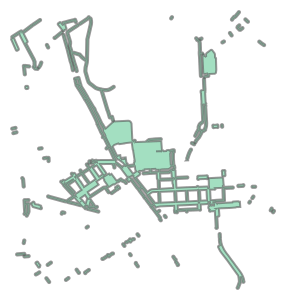

In [138]:
# I made finally a union of all of the unobstructed routes, traffic lights and squares as a one big multipolygon.
geoms = [aaniopasteetyhdiste, alueyhdiste, reittiyhdiste]
etasonKokoelma = shapely.ops.cascaded_union(geoms)
etasonKokoelma

In [139]:
type(etasonKokoelma)

shapely.geometry.multipolygon.MultiPolygon

In [140]:
# Which I still wanted as a geo dataframe since the previous geo dataframes lost the buffer areas as geometry when I changes CRS 
# for some reason.
# I couldn't figure out what was the problem with that, but creating a new geo dataframe solved it.
esteeton = gpd.GeoDataFrame()

In [141]:
esteeton['geometry']= etasonKokoelma

In [142]:
esteeton.crs = CRS.from_epsg(3879)

In [143]:
esteeton = esteeton.to_crs(epsg=4326)

In [144]:
esteeton.head()

geometry
0  POLYGON ((24.94335 60.16644, 24.94336 60.16644...
1  POLYGON ((24.94582 60.16276, 24.94557 60.16294...
2  POLYGON ((24.93370 60.16332, 24.93424 60.16350...
3  POLYGON ((24.92090 60.16334, 24.92088 60.16334...
4  POLYGON ((24.93843 60.16359, 24.93844 60.16358...

In [104]:
esteeton.to_file("Lahtotiedot/esteetonalue.shp")

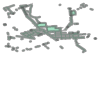

In [145]:
esteetonAluekartalle = esteeton.unary_union
esteetonAluekartalle

In [146]:
x, y = esteetonAluekartalle[0].exterior.coords.xy
print(x[0], y[0])

24.943351033327634 60.166444899933985


In [147]:
import networkx as nx


In [148]:
import fiona; fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

In [149]:
edges.crs = CRS.from_epsg(4326)


In [150]:
edges = edges.to_crs(epsg=4326)

In [151]:
edges.head(5)


u           v  key                   osmid  highway  oneway  \
0  3196174340   913578188    0                 8035247  footway   False   
1  3196174340   308783762    0                28788947  footway   False   
2  3196174340   296556313    0                28788947  footway   False   
3  3196174341  3196174350    0  [313613081, 313613084]  service   False   
4   296043616   295064653    0               317591141  footway   False   

   length                                           geometry  \
0   6.557  LINESTRING (24.92952 60.17323, 24.92941 60.17321)   
1   2.043  LINESTRING (24.92952 60.17323, 24.92951 60.17325)   
2  99.141  LINESTRING (24.92952 60.17323, 24.93032 60.172...   
3  16.615  LINESTRING (24.92993 60.17325, 24.92975 60.173...   
4  63.276  LINESTRING (24.93189 60.17067, 24.93254 60.17021)   

             tunnel name service lanes maxspeed bridge access width  ref  \
0               NaN  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   
1               NaN  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   
2               NaN  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   
3  building_passage  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   
4               NaN  NaN     NaN   NaN      NaN    NaN    NaN   NaN  NaN   

  est_width junction  
0       NaN      NaN  
1       NaN      NaN  
2       NaN      NaN  
3       NaN      NaN  
4       NaN      NaN

In [152]:
#Let's see, what the unobstructed routes look like on an interactive map.
m = folium.Map(location= [center.y, center.x], zoom_start=14, min_zoom = 14, 
               max_zoom= 20, control_scale=True, tiles="CartoDB Positron")
#Add the unobstructed ares to map as geojson.
etasonReititGeoJson.add_to(m)
etasonAlueetGeoJson.add_to(m)
aaniopasteetGeoJson.add_to(m)


In [153]:
#This map is what I used for creating the "Esteettomyyskartta.html", but I modified the html-file 
# to add search form for searching addresses. At that point I thought I could make a little 
# application that searches for routes and shows the map when the addresses are found. 
# In the end I didn't have time to finish that and I didn't have any experience in creating python 
# webapp's so one need's to imagine the final app. 
m

In [154]:
nodes.crs
edges.crs

{'init': 'epsg:4326', 'no_defs': True}

In [155]:
# Here I tested some random addresses that one can test the app with
# One can change these addresses as long as they are in Helsinki center.
origAddress = "Rautatientori, Helsinki"
destAddress = "Punavuorenkatu 19, Helsinki"

# Geocode addresses using Nominatim.
orig = geocode(origAddress, provider='nominatim', user_agent='autogis_xx', 
               timeout=4)
dest = geocode(destAddress, provider='nominatim', user_agent='autogis_xx', 
               timeout=4)

In [156]:
esteetonreititGJ = GeoJson(esteeton, name="esteeton_reitti_alue")

In [157]:
# So here is the app to find path. 
#It shows on the maps which parts are unobstructed and which are not

# Here we change the order of x and y for osmnx and folium.
orig_yx = (orig['geometry'].at[0].y, orig['geometry'].at[0].x)
dest_yx = (dest['geometry'].at[0].y, dest['geometry'].at[0].x)

# Find the nearest node in the graph to the coordinates
oNearest = ox.get_nearest_node(graph, orig_yx, method='euclidean')
dNearest = ox.get_nearest_node(graph, dest_yx, method='euclidean')

#These are the right nodes that we can now extract from nodes.
origo = nodes.loc[oNearest]
destination = nodes.loc[dNearest]

# Let's make a geodataframe with the origin and destination nodes.
odNodes = gpd.GeoDataFrame([origo, destination], geometry='geometry', crs=nodes.crs)

# Find the shortest route with networkx.
route = nx.shortest_path(G=graph, source=oNearest, target=dNearest, weight='length')

# Create a list of coordinates (in the right order) from the route by iterating route.
path = []


for i in range(len(route)-1):
    point = nodes.loc[route[i]].geometry
    path.append([point.y, point.x])
    

                                 
# Now we can make a new map with the wanted route.    
m = folium.Map(location= [path[0][0], path[0][1]], zoom_start=17, min_zoom = 13, max_zoom= 20, control_scale=True, tiles="CartoDB Positron")

# Let's add the unobstructed places again.
etasonReititGeoJson.add_to(m)
etasonAlueetGeoJson.add_to(m)
aaniopasteetGeoJson.add_to(m)

# ...And markers for the start point with address
startMarker = folium.Marker(location= [path[0][0], path[0][1]], popup='Lähtöosoite: ' + origAddress).add_to(m)

# Then test whether the piece of route is on an unobstructed area or not.
for i in range(len(route)-1):
    pathP = []
    
    point1 = Point(nodes.loc[route[i]].geometry.x, nodes.loc[route[i]].geometry.y)
    
    point2 = Point(nodes.loc[route[i+1]].geometry.x, nodes.loc[route[i+1]].geometry.y)
    # First we need to change the order of the lat & lon again for the analysis.
    pathP.append([nodes.loc[route[i]].geometry.y, nodes.loc[route[i]].geometry.x])
    pathP.append([nodes.loc[route[i+1]].geometry.y, nodes.loc[route[i+1]].geometry.x])
    # Then make a linestring of each connected two points.
    lineString = LineString([point1, point2])
    # If both of the points are within the unobstructed area, the line will be colored green.
    if point1.within(esteetonAluekartalle) and point2.within(esteetonAluekartalle):
        attr = {'fill': 'black', 'font-weight': 'bold', 'font-size': '16'}
        pline = folium.PolyLine(pathP, weight=8, color='green', opacity=0.6).add_to(m)
    # Otherwise it will be colored red.
    else:
        attr = {'fill': 'black', 'font-weight': 'bold', 'font-size': '16'}
        pline = folium.PolyLine(pathP, weight=8, color='red', opacity=0.6).add_to(m)
# Then we also add an endmarker with the destination address.        
endMarker = folium.Marker(location= [path[len(path)-1][0], path[len(path)-1][1]], popup='Määränpää: ' + destAddress).add_to(m)

# ...And show the map.
m

In [158]:
# Now we can save the resulting map.
m.save("docs/valitulostus1.html")